# Kapitel 6.7: Deutungen

Das Notebook ergänzt Kapitel 6.7 'Deutungen'.

# Import

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations

from resources_statistics import *
from resources_geschichtslyrik import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator

from tqdm.notebook import tqdm

In [2]:
meta = pd.read_json(r"../resources/meta.json")

# Korpora

### Korpora erstellen

In [3]:
meta_anth = (
    meta
    .query("corpus=='anth'")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)
meta_anth_bin = binarize_meta(meta_anth)

In [4]:
modcanon_authors = ['Hofmannsthal, Hugo von', 'Rilke, Rainer Maria', 'George, Stefan', 'Heym, Georg']

meta_modcanon = (
    meta
    .query("author in @modcanon_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)

In [5]:
muench_authors = ['Münchhausen, Börries von', 'Miegel, Agnes', 'Strauß und Torney, Lulu von']

meta_muench = (
    meta
    .query("author in @muench_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)

In [6]:
sub_df = pd.DataFrame()
sub_names = ['Anthologien', 'Kanonisierte Moderne', 'Münchhausen-Kreis']
sub_metas = [meta_anth, meta_modcanon, meta_muench]

### Merkmale berechnen

In [7]:
for this_name, this_meta in zip(sub_names, sub_metas):
    sub_df.loc[this_name, 'Jahr'] = round(this_meta['year'].mean(), 0)
    sub_df.loc[this_name, 'Texte'] = this_meta.shape[0]

    sub_df.loc[this_name, 'heroismus'] = this_meta.query("heroismus == 1").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, 'nationalismus'] = this_meta.query("nationalismus == 1").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, 'religiositaet'] = this_meta.query("religiositaet == 1").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, 'deutungen_per_text'] = (
        (this_meta.query("heroismus == 1").shape[0] +
        this_meta.query("nationalismus == 1").shape[0] +
        this_meta.query("religiositaet == 1").shape[0])
        /this_meta.shape[0]
    )

In [8]:
round(sub_df, 2)

,Jahr,Texte,heroismus,nationalismus,religiositaet,deutungen_per_text
Anthologien,1875.0,1850.0,0.28,0.14,0.17,0.59
Kanonisierte Moderne,1903.0,113.0,0.09,0.00,0.04,0.13
Münchhausen-Kreis,1905.0,140.0,0.06,0.01,0.04,0.12


# Zeitverlauf

In [9]:
ts = pd.DataFrame()
ts.index = pd.Series(range(1850, 1919), name = 'year')

In [10]:
ts['text_count'] = meta_anth.groupby('year').size()
ts['text_count'] = ts['text_count'].fillna(0)
ts['text_sum'] = smooth(ts['text_count'], mode = 'sum')

In [11]:
ts['heroismus_count'] = [meta_anth.query("year == @x and heroismus == 1").shape[0] for x in ts.index]
ts['heroismus_sum'] = smooth(ts['heroismus_count'], mode = 'sum')
ts['heroismus_share_smoothed'] = ts['heroismus_sum']/ts['text_sum']

ts['nationalismus_count'] = [meta_anth.query("year == @x and nationalismus == 1").shape[0] for x in ts.index]
ts['nationalismus_sum'] = smooth(ts['nationalismus_count'], mode = 'sum')
ts['nationalismus_share_smoothed'] = ts['nationalismus_sum']/ts['text_sum']

ts['religiositaet_count'] = [meta_anth.query("year == @x and religiositaet == 1").shape[0] for x in ts.index]
ts['religiositaet_sum'] = smooth(ts['religiositaet_count'], mode = 'sum')
ts['religiositaet_share_smoothed'] = ts['religiositaet_sum']/ts['text_sum']

ts['deutungen_count'] = ts['heroismus_count'] + ts['nationalismus_count'] + ts['religiositaet_count']
ts['deutungen_sum'] = smooth(ts['deutungen_count'], mode = 'sum')
ts['deutungen_per_text_smoothed'] = ts['deutungen_sum']/ts['text_sum']

# Überblick

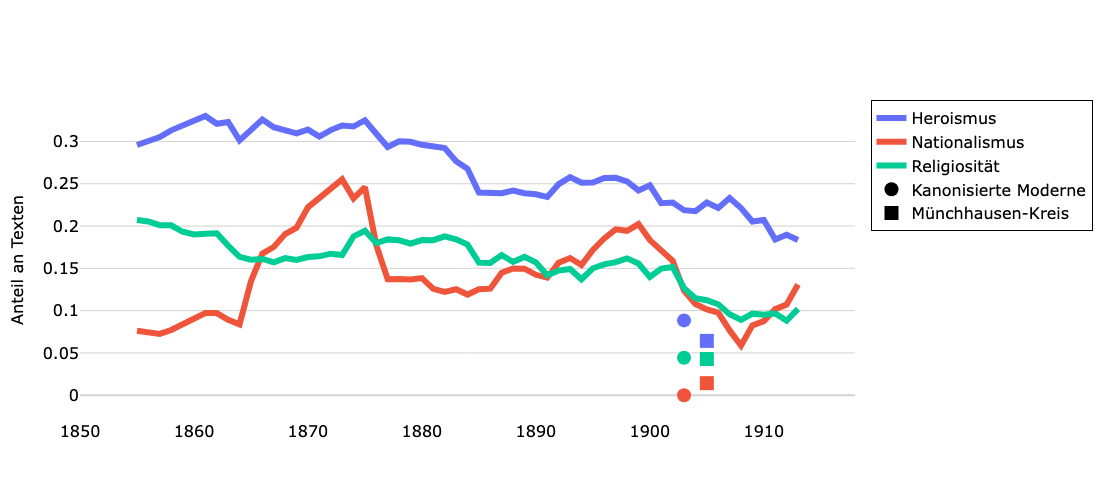

In [61]:
meta_plot = ts[[
    'heroismus_share_smoothed', 
    'nationalismus_share_smoothed', 
    'religiositaet_share_smoothed',
]]
meta_plot.columns = [
    'Heroismus', 
    'Nationalismus', 
    'Religiosität',
]
save_ts_data(meta_plot, prefix='06_07_Deutungen_')

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Texten',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['heroismus', 'nationalismus', 'religiositaet']
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.7 Heroismus, Nationalismus und Religiosität im Zeitverlauf.pdf")
fig.show()

In [13]:
meta_anth_bin['period'] = [0 if 1850 <= x <= 1884 else 1 for x in meta_anth_bin['year']]

results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = 'period',
    comp_features = ['heroismus', 'nationalismus', 'religiositaet']
)

round(results.sort_values(by='diff', ascending=False), 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
nationalismus,0.13,181/1346,0.14,72/504,-0.02,-0.03,0.01,0.04,0.05,0.22,0.64,0.65,0.01,72.0,68.93
religiositaet,0.18,247/1346,0.14,71/504,-0.08,-0.08,-0.04,-0.01,-0.00,4.68,0.03,0.03,0.05,71.0,86.63
heroismus,0.31,411/1346,0.22,112/504,-0.13,-0.13,-0.08,-0.04,-0.04,12.50,0.00,0.00,0.08,112.0,142.48


In [14]:
# Texte 1870/71
meta_1870 = meta_anth.query("1870 <= year <= 1871").copy()
meta_1870['krieg_gegenwart'] = [1 if 'Krieg' in x and y == 0 else 0 for x, y in zip(meta_1870['stoffgebiet'], meta_1870['vergangenheitsdominant'])]
contingency_table = pd.crosstab(meta_1870['nationalismus'], meta_1870['krieg_gegenwart'])

print(contingency_table)
print("\n")
print(f"chi2   : {chi2_contingency(contingency_table)[0]}")
print(f"chi2 p : {chi2_contingency(contingency_table)[1]}")
print(f"phi    : {get_phi(np.array(contingency_table))}")

krieg_gegenwart   0   1
nationalismus          
0.0              38  14
1.0              27  30


chi2   : 6.436283331209948
chi2 p : 0.01118123465584003
phi    : 0.2617175554294466


In [15]:
# Texte 1897/98
meta_1870 = meta_anth.query("1897 <= year <= 1898").copy()
meta_1870['wilhelm_bismarck'] = [1 if 'Wilhelm I.' in x or 'Bismarck' in x else 0 for x in meta_1870['entity_full']]
contingency_table = pd.crosstab(meta_1870['nationalismus'], meta_1870['wilhelm_bismarck'])

print(contingency_table)
print(f"fisher   : {fisher_exact(contingency_table)[0]}")
print(f"fisher p : {fisher_exact(contingency_table)[1]}")
print(f"phi      : {get_phi(np.array(contingency_table))}")

wilhelm_bismarck   0  1
nationalismus          
0.0               19  3
1.0                1  8
fisher   : 50.666666666666664
fisher p : 0.0001664180316789496
phi      : 0.7139081384319523


In [16]:
# Texte 1914/18
meta_1914 = meta_anth_bin.query("1914 <= year <= 1918").copy()
meta_1914['krieg_gegenwart'] = [1 if x == 1 and y == 1 else 0 for x, y in zip(meta_1914['krieg'], meta_1914['gegenwartsdominant'])]
contingency_table = pd.crosstab(meta_1914['nationalismus'], meta_1914['krieg_gegenwart'])

print(contingency_table)
print("\n")
print(f"fisher   : {fisher_exact(contingency_table)[0]}")
print(f"fisher p : {fisher_exact(contingency_table)[1]}")
print(f"phi      : {get_phi(np.array(contingency_table))}")

krieg_gegenwart   0  1
nationalismus         
0.0              28  9
1.0               6  7


fisher   : 3.6296296296296298
fisher p : 0.08242528415219422
phi      : 0.2775980150199401


In [17]:
meta_plot = ts[['deutungen_per_text_smoothed']]
meta_plot.columns = ['Deutungen pro Text']

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Texten',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['deutungen_per_text']
)
fig.show()

In [18]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = 'nationalismus',
    comp_features = ['heroismus', 'religiositaet']
)
round(results, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
heroismus,0.26,412/1597,0.44,111/253,0.11,0.12,0.18,0.25,0.24,35.19,0.0,0.0,0.14,111.0,71.52
religiositaet,0.15,240/1597,0.31,78/253,0.10,0.10,0.16,0.22,0.22,38.31,0.0,0.0,0.14,78.0,43.49


In [19]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = 'heroismus',
    comp_features = ['religiositaet']
)
round(results, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
religiositaet,0.16,211/1327,0.2,107/523,0.01,0.01,0.05,0.09,0.09,5.48,0.02,0.02,0.05,107.0,89.9


# Heroismus

In [20]:
main_feature = 'heroismus'

In [21]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(20)

heroismus                               1.000000
unbekanntes_individuum_positiv          0.309271
entity_positiv                          0.294308
bekanntes_individuum_positiv            0.277802
krieg_positiv                           0.276537
krieg                                   0.248916
ueberlieferung_positiv                  0.232681
kollektiv_positiv                       0.221385
fixierbarkeit                           0.179551
sprechinstanz_nicht_in_vergangenheit    0.176901
marker_count                            0.168803
stoffgebiet_positiv                     0.167379
ortmarker_vorhanden                     0.164351
words                                   0.164269
liebe_negativ                           0.158114
religion_positiv                        0.155404
politik_positiv                         0.150203
nationalismus                           0.137914
nation_volk_d_positiv                   0.135351
ueberlieferung                          0.126413
Name: heroismus, dty

In [22]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

rollengedicht                     -0.186768
krieg_negativ                     -0.183105
entity_neutral                    -0.177260
sprechinstanz_in_vergangenheit    -0.167335
stoffgebiet_neutral               -0.144608
religion_negativ                  -0.097317
ueberlieferung_negativ            -0.093884
unbekanntes_individuum_count      -0.090588
religion                          -0.087040
sprechakt_beschreiben_vorhanden   -0.087020
year_predict_ages_mean            -0.084548
period                            -0.082185
decade                            -0.079516
year                              -0.078813
geschichtsauffassung_negativ      -0.063062
antike                            -0.061992
nichtmensch_count                 -0.060986
stoffgebiet_negativ               -0.058903
verfremdung                       -0.056760
in_hohem_mass_konkret             -0.048917
Name: heroismus, dtype: float64

In [23]:
threshold = 0.2

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [24]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [25]:
directly_related = [
    'entity_positiv', # related to other entities
]
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("chi2_p < 0.05 and min_expected >= 5 and phi >= @threshold")
    .sort_values(by = 'diff', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
krieg_positiv,0.41,193/469,0.69,227/328,0.21,0.21,0.28,0.35,0.35,60.95,0.0,0.0,0.28,101.0,155.15
krieg,0.35,469/1327,0.63,328/523,0.22,0.22,0.27,0.32,0.32,114.62,0.0,0.0,0.25,195.0,225.31
unbekanntes_individuum_positiv,0.29,148/506,0.55,69/125,0.16,0.16,0.26,0.36,0.36,29.92,0.0,0.0,0.22,56.0,42.99
bekanntes_individuum_positiv,0.49,674/1370,0.73,478/655,0.19,0.19,0.24,0.28,0.28,102.17,0.0,0.0,0.22,177.0,282.38
ueberlieferung_positiv,0.47,126/266,0.71,118/166,0.14,0.15,0.24,0.33,0.32,23.39,0.0,0.0,0.23,48.0,72.24


In [26]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='diff', ascending=False), 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
entity_positiv,0.41,1136/2758,0.63,735/1158,0.19,0.19,0.22,0.26,0.26,162.29,0.00,0.00,0.20,423.0,553.27
stoffgebiet_positiv,0.41,757/1825,0.60,427/715,0.14,0.14,0.18,0.22,0.23,68.69,0.00,0.00,0.16,288.0,333.29
kollektiv_positiv,0.32,230/724,0.49,166/340,0.11,0.11,0.17,0.23,0.23,28.80,0.00,0.00,0.16,166.0,126.54
stoffgebiet_ambivalent,0.14,248/1825,0.13,90/715,-0.04,-0.04,-0.01,0.02,0.02,0.45,0.50,0.52,0.01,90.0,95.15
entity_ambivalent,0.07,186/2758,0.05,58/1158,-0.03,-0.03,-0.02,-0.00,-0.00,4.20,0.04,0.04,0.03,58.0,72.15
unbekanntes_individuum_negativ,0.13,68/506,0.10,13/125,-0.09,-0.09,-0.03,0.03,0.03,0.83,0.36,0.46,0.04,13.0,16.05
entity_negativ,0.17,481/2758,0.14,163/1158,-0.06,-0.06,-0.03,-0.01,-0.01,6.72,0.01,0.01,0.04,163.0,190.44
bekanntes_individuum_negativ,0.15,204/1370,0.11,72/655,-0.07,-0.07,-0.04,-0.01,-0.01,5.72,0.02,0.02,0.05,72.0,89.27
kollektiv_negativ,0.27,193/724,0.22,75/340,-0.10,-0.10,-0.05,0.01,0.01,2.60,0.11,0.11,0.05,75.0,85.64
stoffgebiet_negativ,0.22,410/1825,0.18,126/715,-0.08,-0.08,-0.05,-0.01,-0.02,7.24,0.01,0.01,0.05,126.0,150.88


In [27]:
result_categories = ['wenn_nicht', 'wenn_nicht_detail', 'wenn_ja', 'wenn_ja_detail', 'diff', 'chi2_p', 'phi',]

results_a = relations_binbin(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_binbin(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_diffs'] = results_merged['diff_1885'] - results_merged['diff_1850']
results_merged['diff_of_phis'] = results_merged['phi_1885'] - results_merged['phi_1850']

round(results_merged.sort_values(by = 'diff_of_phis'), 3)

,wenn_nicht_1850,wenn_nicht_detail_1850,wenn_ja_1850,wenn_ja_detail_1850,diff_1850,chi2_p_1850,phi_1850,wenn_nicht_1885,wenn_nicht_detail_1885,wenn_ja_1885,wenn_ja_detail_1885,diff_1885,chi2_p_1885,phi_1885,diff_of_diffs,diff_of_phis
krieg,0.313,293/935,0.642,264/411,0.329,0.000,0.308,0.449,176/392,0.571,64/112,0.122,0.022,0.102,-0.207,-0.206
unbekanntes_individuum_positiv,0.320,98/306,0.588,47/80,0.267,0.000,0.224,0.250,50/200,0.489,22/45,0.239,0.001,0.203,-0.028,-0.021
krieg_positiv,0.440,129/293,0.697,184/264,0.257,0.000,0.258,0.364,64/176,0.672,43/64,0.308,0.000,0.274,0.052,0.016
bekanntes_individuum_positiv,0.511,528/1033,0.735,399/543,0.224,0.000,0.216,0.433,146/337,0.705,79/112,0.272,0.000,0.235,0.048,0.020
ueberlieferung_positiv,0.533,97/182,0.721,93/129,0.188,0.001,0.190,0.345,29/84,0.676,25/37,0.330,0.001,0.306,0.142,0.116


In [28]:
results = relations_bincont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

In [29]:
results

""


# Nationalismus

### Ländervergleich

In [30]:
countries = ['Deutschland', 'Österreich', 'Schweiz', 'corpus']

In [31]:
results = pd.DataFrame()
for country in countries:
    if country == 'corpus':
        meta_anth_country = meta_anth
    else:
        meta_anth[country] = [1 if pd.notna(x) and country in x else 0 if pd.notna(x) else float('NaN') for x in meta_anth['author_gnd_countries']]
        meta_anth_country = meta_anth[meta_anth[country] == 1]
    
    results.loc[country, 'authors'] = meta_anth_country['author'].nunique()
    results.loc[country, 'texts'] = meta_anth_country.shape[0]
    results.loc[country, 'nationalismus'] = meta_anth_country.query("nationalismus == 1").shape[0]
    results.loc[country, 'kein_nationalismus'] = meta_anth_country.query("nationalismus == 0").shape[0]

results['nationalismus_share'] = results['nationalismus']/results['texts']

results

,authors,texts,nationalismus,kein_nationalismus,nationalismus_share
Deutschland,407.0,1513.0,217.0,1296.0,0.143424
Österreich,76.0,242.0,31.0,211.0,0.128099
Schweiz,31.0,116.0,7.0,109.0,0.060345
corpus,528.0,1850.0,253.0,1597.0,0.136757


In [32]:
# Tests
countries = [x for x in countries if x != 'corpus']
pairs = list(combinations(countries, 2))
for pair in pairs:
    country_a = pair[0]
    country_b = pair[1]
    
    contingency_table = [
        [meta_anth[meta_anth[country_a] == 1].query("nationalismus == 1").shape[0], 
         meta_anth[meta_anth[country_a] == 1].query("nationalismus == 0").shape[0]], 
        [meta_anth[meta_anth[country_b] == 1].query("nationalismus == 1").shape[0], 
         meta_anth[meta_anth[country_b] == 1].query("nationalismus == 0").shape[0]], 
    ]
    contingency_table_df = pd.DataFrame(contingency_table)
    contingency_table_df.columns = ['nationalismus', 'kein_nationalismus']
    contingency_table_df.index = [country_a, country_b]

    chi2 = chi2_contingency(contingency_table_df)

    print(f"{country_a} vs. {country_b}")
    print(contingency_table_df)
    print(f"chi2   : {chi2[0]}")
    print(f"chi2 p : {chi2[1]}")
    print("\n")

Deutschland vs. Österreich
             nationalismus  kein_nationalismus
Deutschland            217                1296
Österreich              31                 211
chi2   : 0.2873575793383042
chi2 p : 0.5919188527980483


Deutschland vs. Schweiz
             nationalismus  kein_nationalismus
Deutschland            217                1296
Schweiz                  7                 109
chi2   : 5.589164638365113
chi2 p : 0.018071912701037213


Österreich vs. Schweiz
            nationalismus  kein_nationalismus
Österreich             31                 211
Schweiz                 7                 109
chi2   : 3.1134840942369983
chi2 p : 0.07764669880025785




### Annotierte Merkmale

In [33]:
main_feature = 'nationalismus'

In [34]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(20)

nationalismus                           1.000000
nation_volk_d                           0.416343
gegenwartsdominant                      0.396130
gegenwartsbezug                         0.370030
sprechinstanz_nicht_in_vergangenheit    0.308706
krieg_positiv                           0.298258
wissen_identisch                        0.282898
kollektiv_positiv                       0.256427
stoffgebiet_positiv                     0.254551
sprechakt_behaupten_vorhanden           0.253730
neuzeit                                 0.246590
ende                                    0.245150
zeit_mitte                              0.243299
nogenre                                 0.241031
beginn                                  0.236099
politik_positiv                         0.228762
tod_positiv                             0.222436
nation_volk_d_positiv                   0.214259
zeitebenen                              0.208573
sprechinstanz_markiert                  0.196863
Name: nationalismus,

In [35]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

wissen_ergaenzend                -0.304694
in_hohem_mass_konkret            -0.244200
konkretheit                      -0.239934
ballade                          -0.214500
geschichtsauffassung_negativ     -0.195438
nation_volk_d_negativ            -0.173990
mittelalter                      -0.170806
sprechakt_erzaehlen_vorhanden    -0.168332
krieg_negativ                    -0.157424
stoffgebiet_neutral              -0.153114
ereignis                         -0.142967
entity_neutral                   -0.139717
religion                         -0.127650
antike                           -0.126415
sprechinstanz_in_vergangenheit   -0.110215
stoffgebiet_negativ              -0.103728
unbekanntes_individuum_count     -0.100729
unbekanntes_individuum_negativ   -0.095226
kleinraum_count                  -0.092309
tod_negativ                      -0.076042
Name: nationalismus, dtype: float64

In [36]:
threshold = 0.2

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
bin_comp_features = bin_comp_features + ['religiositaet', 'heroismus', 'sprechinstanz_markiert']
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [37]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [38]:
directly_related = [
    'gegenwartsdominant', 'sprechinstanz_nicht_in_vergangenheit', # related to gegenwartsbezug
    'wissen_ergaenzend', # related to wissen_identisch
    'ballade', # related to nogenre
]
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("chi2_p < 0.05 and min_expected >= 5 and phi >= @threshold")
    .sort_values(by = 'diff', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
gegenwartsbezug,0.22,356/1597,0.71,180/253,0.43,0.43,0.49,0.55,0.54,253.31,0.0,0.0,0.37,73.0,73.30
krieg_positiv,0.46,305/663,0.86,115/134,0.33,0.33,0.40,0.47,0.47,70.90,0.0,0.0,0.30,19.0,63.39
neuzeit,0.49,786/1597,0.85,215/253,0.31,0.31,0.36,0.41,0.41,112.49,0.0,0.0,0.25,38.0,116.11
stoffgebiet_positiv,0.42,915/2181,0.75,269/359,0.28,0.28,0.33,0.38,0.38,134.71,0.0,0.0,0.23,90.0,167.34
politik_positiv,0.51,118/232,0.80,41/51,0.17,0.17,0.30,0.42,0.41,14.81,0.0,0.0,0.23,10.0,22.35
nogenre,0.19,300/1597,0.48,122/253,0.23,0.23,0.29,0.36,0.36,107.48,0.0,0.0,0.24,122.0,57.71
kollektiv_positiv,0.32,282/878,0.61,114/186,0.22,0.22,0.29,0.37,0.37,55.90,0.0,0.0,0.23,72.0,69.23
wissen_identisch,0.10,165/1597,0.39,99/253,0.22,0.23,0.29,0.35,0.35,148.06,0.0,0.0,0.28,99.0,36.10
sprechakt_behaupten_vorhanden,0.15,235/1597,0.43,110/253,0.22,0.22,0.29,0.35,0.35,119.10,0.0,0.0,0.25,110.0,47.18
nation_volk_d,0.00,3/1597,0.21,53/253,0.16,0.16,0.21,0.26,0.26,320.68,0.0,0.0,0.42,3.0,7.66


In [39]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='diff', ascending=False), 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
nation_volk_d_positiv,0.33,1/3,0.75,40/53,-0.21,-0.12,0.42,0.97,0.83,2.57,0.11,0.17,0.21,1.0,0.80
gegenwartsdominant,0.09,142/1597,0.49,125/253,0.34,0.34,0.41,0.47,0.47,290.30,0.00,0.00,0.40,125.0,36.51
sprechinstanz_nicht_in_vergangenheit,0.22,355/1597,0.62,158/253,0.34,0.34,0.40,0.47,0.46,176.30,0.00,0.00,0.31,95.0,70.16
sprechinstanz_markiert,0.40,638/1597,0.68,173/253,0.22,0.22,0.28,0.35,0.35,71.70,0.00,0.00,0.20,80.0,110.91
entity_positiv,0.45,1519/3401,0.68,352/515,0.19,0.19,0.24,0.28,0.28,100.57,0.00,0.00,0.16,163.0,246.06
bekanntes_individuum_positiv,0.54,966/1781,0.76,186/244,0.16,0.16,0.22,0.28,0.28,42.31,0.00,0.00,0.14,58.0,105.19
tod_positiv,0.09,17/191,0.31,8/26,0.04,0.04,0.22,0.40,0.39,10.74,0.00,0.00,0.22,8.0,3.00
heroismus,0.26,412/1597,0.44,111/253,0.12,0.12,0.18,0.25,0.25,35.19,0.00,0.00,0.14,111.0,71.52
unbekanntes_individuum_positiv,0.33,196/590,0.51,21/41,0.02,0.02,0.18,0.34,0.33,5.50,0.02,0.03,0.09,20.0,14.10
religiositaet,0.15,240/1597,0.31,78/253,0.10,0.10,0.16,0.22,0.22,38.31,0.00,0.00,0.14,78.0,43.49


In [40]:
result_categories = ['wenn_nicht', 'wenn_nicht_detail', 'wenn_ja', 'wenn_ja_detail', 'diff', 'chi2_p', 'phi',]

results_a = relations_binbin(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_binbin(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_diffs'] = results_merged['diff_1885'] - results_merged['diff_1850']
results_merged['diff_of_phis'] = results_merged['phi_1885'] - results_merged['phi_1850']

round(results_merged.sort_values(by = 'diff_of_phis'), 3)

,wenn_nicht_1850,wenn_nicht_detail_1850,wenn_ja_1850,wenn_ja_detail_1850,diff_1850,chi2_p_1850,phi_1850,wenn_nicht_1885,wenn_nicht_detail_1885,wenn_ja_1885,wenn_ja_detail_1885,diff_1885,chi2_p_1885,phi_1885,diff_of_diffs,diff_of_phis
neuzeit,0.458,533/1165,0.829,150/181,0.371,0.000,0.253,0.586,253/432,0.903,65/72,0.317,0.000,0.230,-0.054,-0.023
gegenwartsbezug,0.224,261/1165,0.718,130/181,0.494,0.000,0.371,0.220,95/432,0.694,50/72,0.475,0.000,0.367,-0.020,-0.005
kollektiv_positiv,0.325,221/679,0.616,90/146,0.291,0.000,0.229,0.307,61/199,0.600,24/40,0.293,0.000,0.229,0.003,-0.000
nation_volk_d,0.001,1/1165,0.199,36/181,0.198,0.000,0.413,0.005,2/432,0.236,17/72,0.231,0.000,0.425,0.033,0.012
nogenre,0.158,184/1165,0.425,77/181,0.267,0.000,0.231,0.269,116/432,0.625,45/72,0.356,0.000,0.268,0.089,0.037
sprechakt_behaupten_vorhanden,0.138,161/1165,0.403,73/181,0.265,0.000,0.239,0.171,74/432,0.514,37/72,0.343,0.000,0.289,0.077,0.051
krieg_positiv,0.498,229/460,0.866,84/97,0.368,0.000,0.281,0.374,76/203,0.838,31/37,0.463,0.000,0.337,0.095,0.055
stoffgebiet_positiv,0.455,730/1603,0.769,193/251,0.314,0.000,0.215,0.320,185/578,0.704,76/108,0.384,0.000,0.288,0.070,0.073
in_hohem_mass_konkret,0.857,998/1165,0.613,111/181,-0.243,0.000,0.218,0.852,368/432,0.500,36/72,-0.352,0.000,0.309,-0.108,0.091
wissen_identisch,0.099,115/1165,0.337,61/181,0.238,0.000,0.241,0.116,50/432,0.528,38/72,0.412,0.000,0.380,0.174,0.139


In [41]:
results = relations_bincont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

In [42]:
round(results.sort_values(by = 'pointbiserialr_corr', ascending = False), 2)

,wenn_nicht,a_merkmal=0,a_merkmal=1,a_merkmal=2,a_merkmal=3,a_merkmal>=4,wenn_ja,b_merkmal=0,b_merkmal=1,b_merkmal=2,...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p,meandiffs_ci_lower,meandiffs_ci_bootstrap_lower,meandiffs_ci_upper,meandiffs_ci_bootstrap_upper
ende,1244.84,0.0 [5/1590],0.0 [0/1590],0.0 [0/1590],0.0 [0/1590],0.92 [1459/1590],1727.17,0.0 [0/252],0.0 [0/252],0.0 [0/252],...,0.25,0.0,0.0,-0.88,73108.5,0.0,395.12,426.29,569.54,535.68
zeit_mitte,1231.84,0.0 [7/1590],0.0 [0/1590],0.0 [0/1590],0.0 [0/1590],0.92 [1455/1590],1714.99,0.0 [0/252],0.0 [0/252],0.0 [0/252],...,0.24,0.0,0.0,-0.87,74364.5,0.0,395.08,424.83,571.21,537.16
beginn,1218.85,0.01 [9/1590],0.0 [0/1590],0.0 [0/1590],0.0 [0/1590],0.91 [1446/1590],1702.81,0.0 [0/252],0.0 [0/252],0.0 [0/252],...,0.24,0.0,0.0,-0.83,75685.0,0.0,392.88,419.01,575.02,539.69
zeitebenen,1.95,0.0 [0/1597],0.31 [498/1597],0.46 [742/1597],0.19 [296/1597],0.04 [61/1597],2.47,0.0 [0/253],0.11 [28/253],0.44 [112/253],...,0.21,0.0,0.0,-0.60,137540.5,0.0,0.41,0.40,0.63,0.64
konkretheit,0.92,0.01 [16/1597],0.86 [1366/1597],0.0 [0/1597],0.0 [0/1597],0.0 [0/1597],0.77,0.04 [9/253],0.58 [147/253],0.0 [0/253],...,-0.24,0.0,0.0,0.62,257631.5,0.0,-0.18,-0.19,-0.12,-0.11


In [43]:
meta_plot = meta_anth_bin.copy()

for cont_comp_feature in cont_comp_features:
    mean_main = meta_plot[meta_plot[main_feature] == 1][cont_comp_feature].mean()
    mean_notmain = meta_plot[meta_plot[main_feature] == 0][cont_comp_feature].mean()
    if cont_comp_feature == 'zeit_mitte':
        label_main = f"Nationalistische Texte<br>(Mittelwert = {round(mean_main)})"
        label_notmain = f"Nicht nationalistische Texte<br>(Mittelwert = {round(mean_notmain)})"
    else:
        label_main = f"Nationalistische Texte<br>(Mittelwert = {round(mean_main, 2)})"
        label_notmain = f"Nicht nationalistische Texte<br>(Mittelwert = {round(mean_notmain, 2)})"
    meta_plot['plot_legend'] = [label_main if x == 1 else label_notmain for x in meta_plot[main_feature]]
    meta_plot['zeit_mitte'] = meta_plot['zeit_mitte'].clip(lower=0)
        
    fig = px.histogram(
        meta_plot,
        x = cont_comp_feature,
        color = 'plot_legend',
        histnorm = 'probability density',
        barmode = 'group',
        labels = {'plot_legend' : '', 
                  'stoffgebiet_positiv' : 'Anzahl positiv bewertete Stoffgebiete',
                  'zeit_mitte' : 'Mitte der dominanten Zeitebene',
                 }
    )

    fig.update_layout(
        width = 700, height = 300,
        yaxis_title="Anteil",
        xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        legend=dict(font = dict(size=16), x=0.5, y = 0.96),
        bargap=0.1
    )
    if cont_comp_feature == 'zeit_mitte':
        fig.update_layout(legend=dict(x=0.15, y = 0.9),)  
        
    # fig.write_image(f"plots/6.7 Nationalismus – {cont_comp_feature}.pdf")
    fig.show()

In [44]:
meta_anth_bin['behandelt_deutschen_mittelraum'].mean()

0.6816216216216217

In [45]:
binarize_meta(meta_muench)['behandelt_deutschen_mittelraum'].mean()

0.5928571428571429

In [46]:
binarize_meta(meta_modcanon)['behandelt_deutschen_mittelraum'].mean()

0.2743362831858407

### Anthologien

In [47]:
def create_anthology_nationalism_plot(
    texts_start = 1850,
    texts_end = 1875,
    only_geschichtslyrik = True,
    anthology_start = 1885,
    min_text_count = 20,
    plot_type = 'bar'
    ):

    anthology_df = pd.DataFrame()
    for anthology in meta.query("anthology_year_used_ed <= 2000")['anthology'].unique():
        anthology_meta = meta.query("anthology == @anthology")
        anthology_texts_meta = anthology_meta.query("@texts_start <= year <= @texts_end")
        if only_geschichtslyrik:
            anthology_texts_meta = anthology_texts_meta.query("geschichtslyrik == 1")
        anthology_df.at[anthology, 'anthology_year'] = anthology_meta['anthology_year_used_ed'].tolist()[0]
        anthology_df.at[anthology, 'annotated_count'] = anthology_texts_meta.query("annotated").shape[0]
        anthology_df.at[anthology, 'nationalismus_count'] = anthology_texts_meta.query("nationalismus == 1").shape[0]
    anthology_df['nationalismus_share'] = anthology_df['nationalismus_count']/anthology_df['annotated_count']

    meta_plot = anthology_df.query("anthology_year >= @anthology_start and annotated_count >= @min_text_count")

    if plot_type == 'bar':
        fig = px.bar(
            meta_plot,
            y = 'nationalismus_share',
            hover_data = ['annotated_count'],
            labels = {'nationalismus_share' : 'Anteil nationalistische Texte', 'index' : ''}
        )
    elif plot_type == 'bubble':
        fig = px.scatter(
            meta_plot,
            x = 'anthology_year',
            y = 'nationalismus_share',
            size = 'annotated_count',
            hover_name = meta_plot.index,
            labels = {'nationalismus_share' : 'Anteil nationalistische Texte', 'anthology_year' : 'Publikationsjahr Anthologie'}
        )
        
    return fig

In [48]:
fig = create_anthology_nationalism_plot(
    texts_start = 1850,
    texts_end = 1875,
    only_geschichtslyrik = True,
    anthology_start = 1885,
    min_text_count = 20,
)
fig.update_layout(
        width=900, height=600,
        xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        legend=dict(font = dict(size=16), traceorder = 'normal'),
        showlegend=False
    )
fig.update_xaxes(tickangle=45)
fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/6.7 Nationalistische Geschichtslyrik nach Anthologien.pdf")
fig.show()

In [49]:
fig = create_anthology_nationalism_plot(
    texts_start = 1850,
    texts_end = 2000,
    only_geschichtslyrik = False,
    anthology_start = 1885,
    min_text_count = 20,
)
fig.update_layout(
    width=1200, height=600,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font = dict(size=16), traceorder = 'normal'),
    showlegend=False
)
fig.update_xaxes(tickangle=45)
fig.show()

# Religiosität

In [50]:
main_feature = 'religiositaet'

In [51]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(20)

religiositaet                           1.000000
religion_positiv                        0.458569
liebe_positiv                           0.319333
geschichtsauffassung_positiv            0.272853
religion                                0.269505
stoffgebiet_positiv                     0.193714
tod_positiv                             0.188286
politik_positiv                         0.182373
sprechinstanz_nicht_in_vergangenheit    0.181845
bekanntes_individuum_positiv            0.181566
sprechakt_behaupten_vorhanden           0.149698
nationalismus                           0.143906
gegenwartsbezug                         0.141699
entity_positiv                          0.137040
ueberlieferung_positiv                  0.129081
ende                                    0.122745
sprechakte_count                        0.122678
zeit_mitte                              0.121334
beginn                                  0.117275
nogenre                                 0.114250
Name: religiositaet,

In [52]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

religion_negativ                 -0.234767
geschichtsauffassung_negativ     -0.182759
entity_neutral                   -0.153711
stoffgebiet_neutral              -0.131207
in_hohem_mass_konkret            -0.122761
konkretheit                      -0.122692
rollengedicht                    -0.118910
liebe_negativ                    -0.114708
tod_negativ                      -0.109694
wissen_ergaenzend                -0.107934
antike                           -0.100265
sprechinstanz_in_vergangenheit   -0.094410
politik_negativ                  -0.093908
year_predict_ages_mean           -0.089214
stoffgebiet_negativ              -0.082987
unbekanntes_individuum_count     -0.075875
decade                           -0.067600
year                             -0.067216
nation_volk_d_negativ            -0.066667
objektmarker_vorhanden           -0.061688
Name: religiositaet, dtype: float64

In [53]:
threshold = 0.2

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [54]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [55]:
directly_related = []
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("chi2_p < 0.05 and min_expected >= 5 and phi >= @threshold")
    .sort_values(by = 'diff', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
religion_positiv,0.30,47/155,0.77,86/112,0.36,0.36,0.46,0.57,0.57,56.15,0.00,0.00,0.46,26.0,55.79
geschichtsauffassung_positiv,0.27,17/62,0.60,9/15,0.06,0.05,0.33,0.60,0.58,5.73,0.02,0.03,0.27,6.0,5.06
religion,0.10,155/1532,0.35,112/318,0.20,0.20,0.25,0.31,0.31,134.37,0.00,0.00,0.27,112.0,45.90
religion_negativ,0.16,25/155,0.02,2/112,-0.21,-0.21,-0.14,-0.08,-0.08,14.72,0.00,0.00,0.23,2.0,11.33


In [56]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='diff', ascending=False), 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
liebe_positiv,0.46,26/57,1.00,6/6,0.40,0.41,0.54,0.67,0.67,6.42,0.01,0.02,0.32,0.0,2.95
bekanntes_individuum_positiv,0.53,896/1689,0.76,256/336,0.18,0.18,0.23,0.28,0.28,61.19,0.00,0.00,0.17,80.0,144.85
stoffgebiet_positiv,0.43,891/2088,0.65,293/452,0.17,0.17,0.22,0.27,0.27,73.26,0.00,0.00,0.17,159.0,210.70
entity_positiv,0.45,1469/3271,0.62,402/645,0.14,0.13,0.17,0.22,0.22,65.49,0.00,0.00,0.13,243.0,308.17
unbekanntes_individuum_positiv,0.33,184/560,0.46,33/71,0.02,0.01,0.14,0.26,0.25,5.18,0.02,0.03,0.09,33.0,24.42
kollektiv_positiv,0.36,307/855,0.43,89/209,0.00,-0.01,0.07,0.14,0.14,3.20,0.07,0.08,0.05,89.0,77.79
kollektiv_negativ,0.25,211/855,0.27,57/209,-0.04,-0.04,0.03,0.09,0.09,0.60,0.44,0.48,0.02,57.0,52.64
stoffgebiet_ambivalent,0.13,275/2088,0.14,63/452,-0.03,-0.03,0.01,0.04,0.04,0.19,0.66,0.65,0.01,63.0,60.15
entity_negativ,0.17,543/3271,0.16,101/645,-0.04,-0.04,-0.01,0.02,0.02,0.35,0.56,0.60,0.01,101.0,106.07
entity_ambivalent,0.06,210/3271,0.05,34/645,-0.03,-0.03,-0.01,0.01,0.01,1.22,0.27,0.29,0.02,34.0,40.19


In [57]:
result_categories = ['wenn_nicht', 'wenn_nicht_detail', 'wenn_ja', 'wenn_ja_detail', 'diff', 'chi2_p', 'phi',]

results_a = relations_binbin(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_binbin(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_diffs'] = results_merged['diff_1885'] - results_merged['diff_1850']
results_merged['diff_of_phis'] = results_merged['phi_1885'] - results_merged['phi_1850']

round(results_merged.sort_values(by = 'diff_of_phis'), 3)

,wenn_nicht_1850,wenn_nicht_detail_1850,wenn_ja_1850,wenn_ja_detail_1850,diff_1850,chi2_p_1850,phi_1850,wenn_nicht_1885,wenn_nicht_detail_1885,wenn_ja_1885,wenn_ja_detail_1885,diff_1885,chi2_p_1885,phi_1885,diff_of_diffs,diff_of_phis
religion,0.115,126/1099,0.401,99/247,0.286,0.000,0.297,0.067,29/433,0.183,13/71,0.116,0.001,0.146,-0.170,-0.151
geschichtsauffassung_positiv,0.234,11/47,0.600,6/10,0.366,0.022,0.304,0.400,6/15,0.600,3/5,0.200,0.436,0.174,-0.166,-0.130
religion_negativ,0.175,22/126,0.020,2/99,-0.154,0.000,0.248,0.103,3/29,0.000,0/13,-0.103,0.229,0.186,0.051,-0.063
religion_positiv,0.333,42/126,0.758,75/99,0.424,0.000,0.422,0.172,5/29,0.846,11/13,0.674,0.000,0.641,0.249,0.220


In [58]:
results = relations_bincont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

In [59]:
results

""


In [60]:
meta_plot = meta_anth_bin.copy()

for cont_comp_feature in cont_comp_features:
    mean_main = meta_plot[meta_plot[main_feature] == 1][cont_comp_feature].mean()
    mean_notmain = meta_plot[meta_plot[main_feature] == 0][cont_comp_feature].mean()
    label_main = f"Religiöse Texte<br>(Mittelwert = {round(mean_main, 2)})"
    label_notmain = f"Nicht religiöse Texte<br>(Mittelwert = {round(mean_notmain, 2)})"
    meta_plot['plot_legend'] = [label_main if x == 1 else label_notmain for x in meta_plot[main_feature]]
        
    fig = px.histogram(
        meta_plot,
        x = cont_comp_feature,
        color = 'plot_legend',
        histnorm = 'probability density',
        barmode = 'group',
        labels = {'plot_legend' : '', 'stoffgebiet_positiv' : 'Anzahl positiv bewertete Stoffgebiete',}
    )

    fig.update_layout(
        width = 700, height = 300,
        yaxis_title="Anteil",
        xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        legend=dict(font = dict(size=16), x=0.6, y = 0.95),
        bargap=0.1
    )
    # fig.write_image(f"plots/6.7 Religiosität – {cont_comp_feature}.pdf")
    fig.show()